In [2]:
# import all the necessary libraries
import numpy as np
import plotly.express as px
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

In [3]:
# Download the Excel file manually from the provided URL and save it to your local directory
# Then specify the file path to the downloaded Excel file
file_path = "Date_Fruit_Datasets.xlsx"

# Read the dataset
dataframe = pd.read_excel(file_path)
#dataframe.head()

In [4]:
dataframe.drop(["PERIMETER","MAJOR_AXIS","MINOR_AXIS","CONVEX_AREA","MeanRR","ALLdaub4RR","EntropyRG"], axis=1, inplace=True)

In [5]:
from sklearn.model_selection import train_test_split

def train_test_split_data(dataframe, target, test_size, random_state):
    # Splitting into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        dataframe.drop([target], axis=1),
        dataframe[target],
        test_size=test_size,
        random_state=random_state,
        stratify=dataframe[target]
    )
    
    # Further split the train set into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(
        x_train,
        y_train,
        test_size=test_size,  # Use the same test_size for validation set
        random_state=random_state,
        stratify=y_train  # Stratify based on the train set
    )

    return x_train, x_val, x_test, y_train, y_val, y_test

In [6]:
x_train, x_val, x_test, y_train, y_val, y_test = train_test_split_data(dataframe, 'Class', test_size=0.2, random_state=42)

In [7]:
def get_numerical_and_categorical_columns(dataframe):
    
    numerical_cols = []
    categorical_cols = []
    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            numerical_cols.append(column)
        else:
            categorical_cols.append(column)
            
    return numerical_cols, categorical_cols

In [8]:
numerical_cols, categorical_cols=get_numerical_and_categorical_columns(dataframe)

In [9]:
def Winsorization_Method(columns, x_train, y_train , a, b):
    outliers=[]

    for col in columns:
        q1= np.percentile(x_train[col], a)
        q2= np.percentile(x_train[col],b)
        
        for pos in range(len(x_train)):
            if x_train[col].iloc[pos]>q2 or x_train[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers= set(outliers)                   # remove the duplicates from the outliers
    outliers= list(outliers)
    
    ratio= round(len(outliers)/len(x_train)*100, 2)                       # Ratio of outliers
    x_train.drop(x_train.index[outliers], inplace=True)    # remove the outliers from the training dataset
    y_train.drop(y_train.index[outliers], inplace=True)
    
    
    
    return ratio, x_train, y_train

In [10]:
ratio_of_outliers,x_train,y_train= Winsorization_Method(numerical_cols, x_train, y_train, a=0.2, b=99.2)

In [11]:
robust_scaler = RobustScaler()
x_train_scaled = robust_scaler.fit_transform(x_train)
x_val_scaled = robust_scaler.transform(x_val)
x_test_scaled = robust_scaler.transform(x_test)   

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

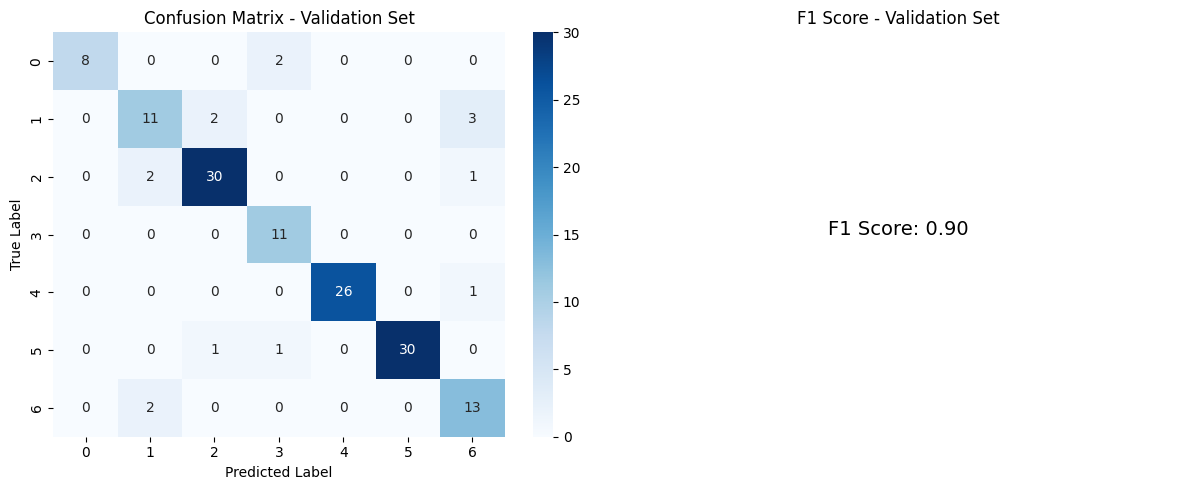

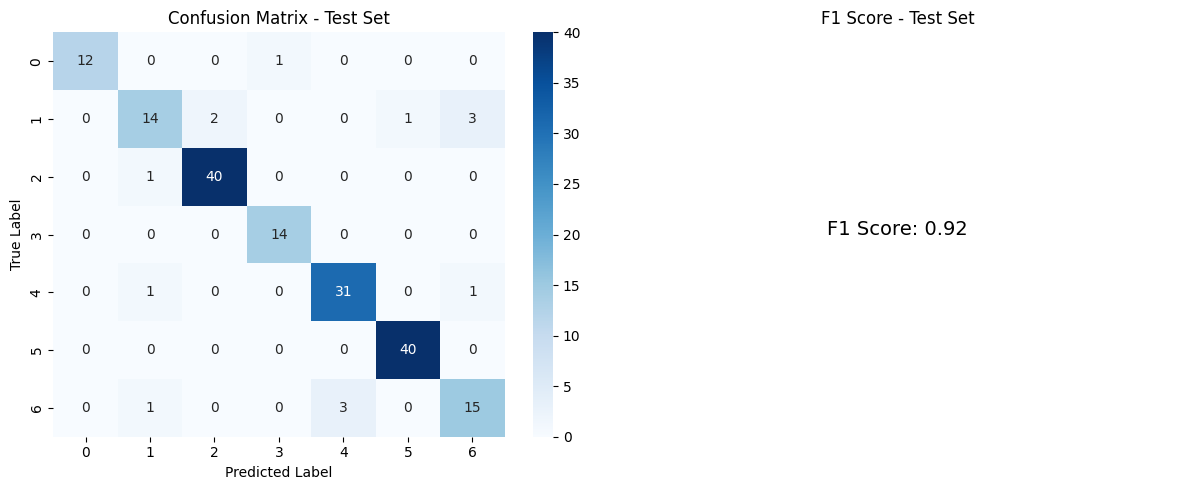

In [12]:
def modelling_logistic_regression(x_train, x_val, x_test, y_train, y_val, y_test):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    # Initialize Logistic Regression model
    model = LogisticRegression(multi_class = "multinomial",solver = 'lbfgs', penalty = 'l2', C = 0.8,max_iter = 50000)

    # Train the Logistic Regression model
    model.fit(x_train, y_train)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage:
modelling_logistic_regression(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded)


  File "c:\Users\Tobi\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Tobi\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Tobi\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Tobi\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


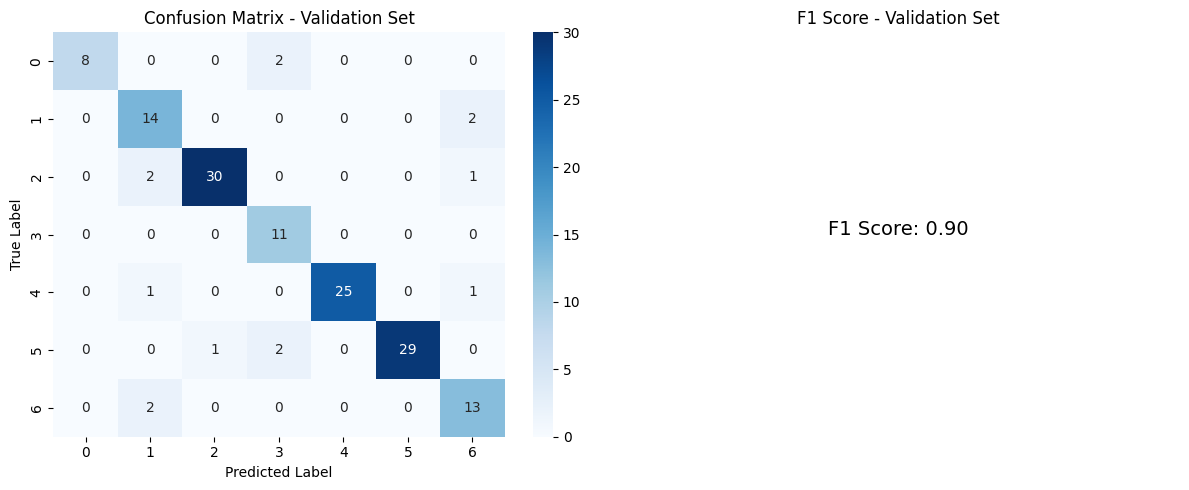

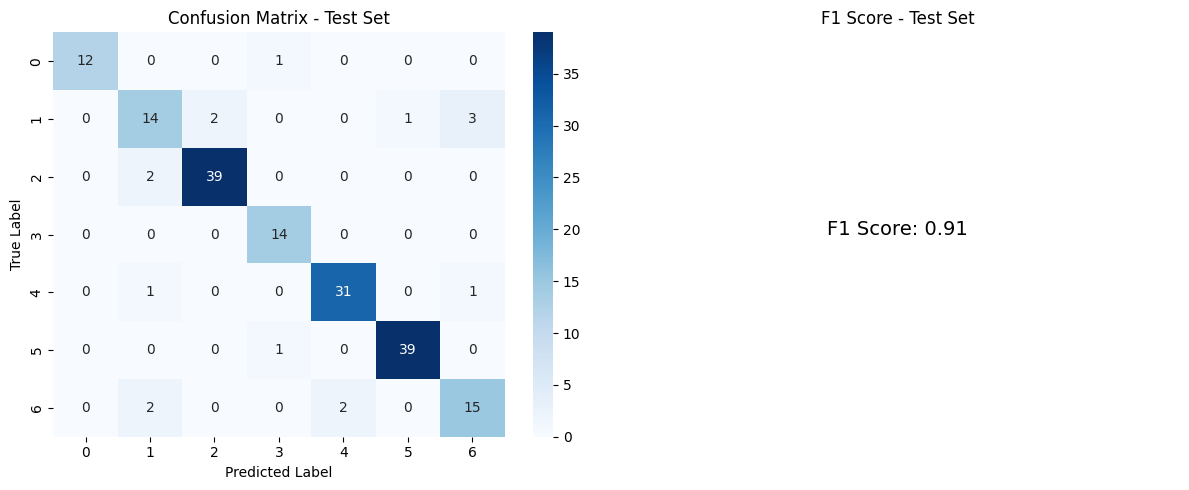

In [13]:
from imblearn.over_sampling import SMOTE

def modelling_logistic_regression(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    if oversample:
        # Perform oversampling on the training data using SMOTE
        smote = SMOTE(random_state=0)
        x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
    else:
        x_train_resampled, y_train_resampled = x_train, y_train

    # Initialize Logistic Regression model
    model = LogisticRegression(multi_class="multinomial", solver='lbfgs', penalty='l2', C=0.8, max_iter=50000)

    # Train the Logistic Regression model
    model.fit(x_train_resampled, y_train_resampled)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage with SMOTE:
modelling_logistic_regression(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True)


Cross Validation F1 Scores: [0.8907563  0.88235294 0.94957983 0.93277311 0.94117647]
Cross-validation F1 Score: 0.92 +/- 0.03


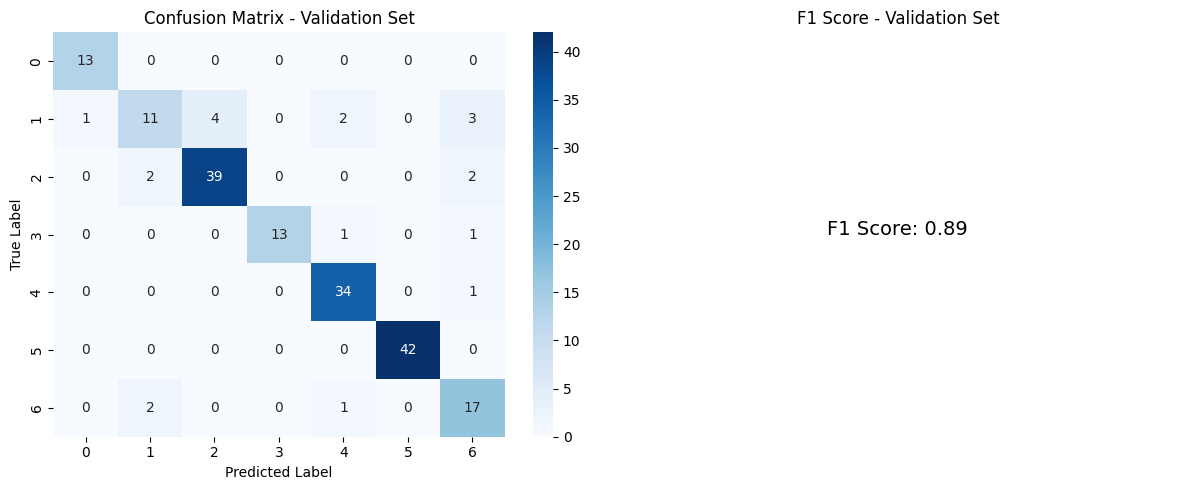

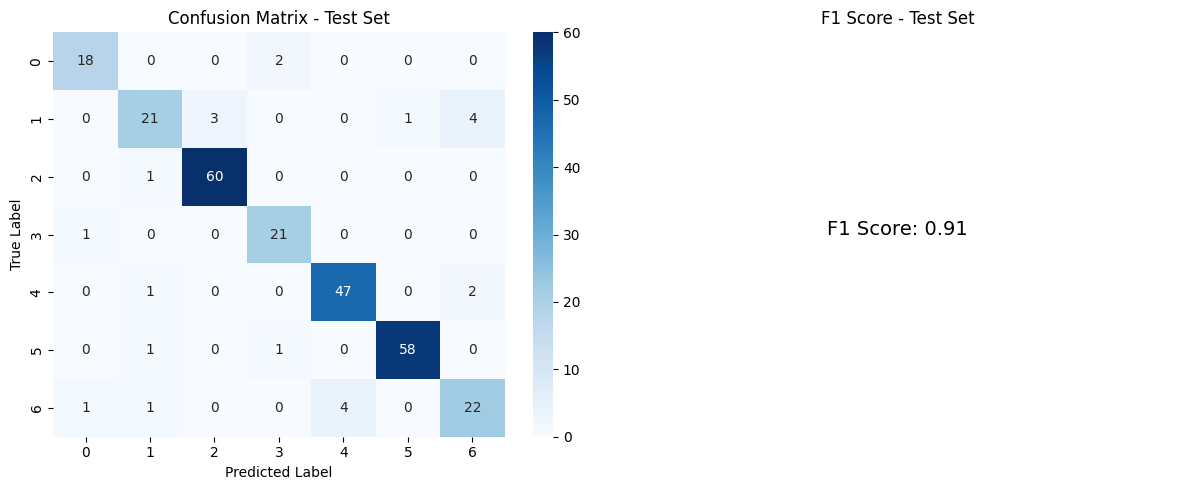

In [30]:
from sklearn.model_selection import cross_val_score

def modelling_logistic_regression_cv(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True, cv=5):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    if oversample:
        # Perform oversampling on the training data using SMOTE
        smote = SMOTE(random_state=0)
        x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
    else:
        x_train_resampled, y_train_resampled = x_train, y_train

    # Initialize Logistic Regression model
    model = LogisticRegression(multi_class="multinomial", solver='lbfgs', penalty='l2', C=0.8, max_iter=50000)

    # Perform cross-validation
    cv_scores = cross_val_score(model, x_train_resampled, y_train_resampled, cv=cv, scoring='f1_micro')

    # Print cross-validation scores
    print("Cross Validation F1 Scores:", cv_scores)

    # Calculate mean and standard deviation of cross-validation scores
    cv_mean_score = cv_scores.mean()
    cv_std_score = cv_scores.std()

    print(f'Cross-validation F1 Score: {cv_mean_score:.2f} +/- {cv_std_score:.2f}')

    # Train the Logistic Regression model on the entire training data
    model.fit(x_train_resampled, y_train_resampled)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage with SMOTE and cross-validation:
modelling_logistic_regression_cv(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True, cv=5)


In [14]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def modelling_logistic_regression_with_c_values(x_train, x_val, x_test, y_train, y_val, y_test, c_values):
    # Create an empty list to store the evaluation results for each value of C
    evaluation_results = []

    for c in c_values:
        # Initialize Logistic Regression model with specified C value
        model = LogisticRegression(C = c)


        # Train the Logistic Regression model
        model.fit(x_train, y_train)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)
        # Predict on the test set
        y_pred_test = model.predict(x_test)

        # Calculate confusion matrix and F1 score for validation set
        confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')

        # Calculate confusion matrix and F1 score for test set
        confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
        f1_score_test = f1_score(y_test, y_pred_test, average='micro')

        # Append evaluation results for the current C value to the list
        evaluation_results.append({
            'C': c,
            'Confusion Matrix Validation': confusion_matrix_val,
            'F1 Score Validation': f1_score_val,
            'Confusion Matrix Test': confusion_matrix_test,
            'F1 Score Test': f1_score_test
        })

        # Print evaluation results for the current C value
        print(f"Evaluation results for C={c}:")
        print(f"Validation Set - F1 Score: {f1_score_val:.4f}")
        print(f"Test Set - F1 Score: {f1_score_test:.4f}")
        print()

    return evaluation_results

# Example usage:
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
evaluation_results = modelling_logistic_regression_with_c_values(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, c_values)


Evaluation results for C=0.1:
Validation Set - F1 Score: 0.8819
Test Set - F1 Score: 0.9111

Evaluation results for C=0.2:
Validation Set - F1 Score: 0.8958
Test Set - F1 Score: 0.9278

Evaluation results for C=0.3:
Validation Set - F1 Score: 0.8889
Test Set - F1 Score: 0.9278

Evaluation results for C=0.4:
Validation Set - F1 Score: 0.8889
Test Set - F1 Score: 0.9167

Evaluation results for C=0.5:
Validation Set - F1 Score: 0.8889
Test Set - F1 Score: 0.9222

Evaluation results for C=0.6:
Validation Set - F1 Score: 0.8889
Test Set - F1 Score: 0.9222

Evaluation results for C=0.7:
Validation Set - F1 Score: 0.8889
Test Set - F1 Score: 0.9222

Evaluation results for C=0.8:
Validation Set - F1 Score: 0.8958
Test Set - F1 Score: 0.9222



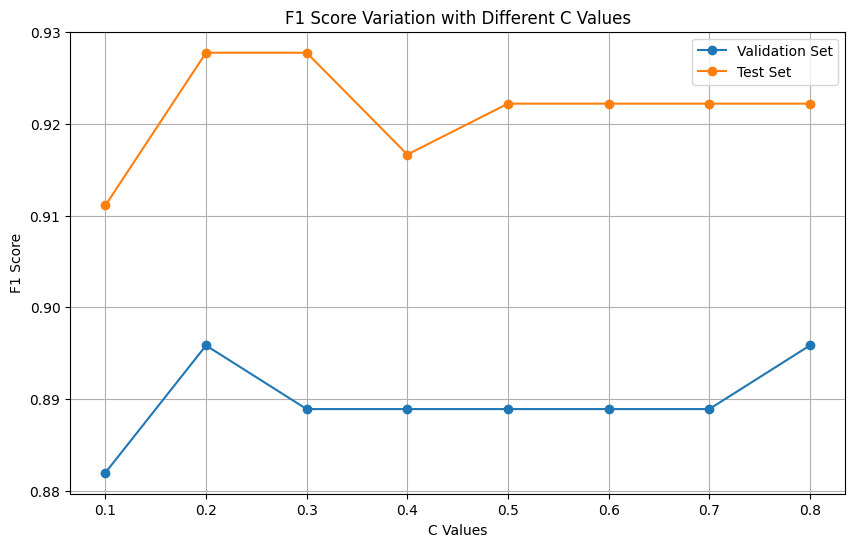

In [15]:
import matplotlib.pyplot as plt

def plot_f1_scores_variation(evaluation_results, c_values):
    f1_scores_val = [result['F1 Score Validation'] for result in evaluation_results]
    f1_scores_test = [result['F1 Score Test'] for result in evaluation_results]

    plt.figure(figsize=(10, 6))
    plt.plot(c_values, f1_scores_val, marker='o', label='Validation Set')
    plt.plot(c_values, f1_scores_test, marker='o', label='Test Set')
    plt.xlabel('C Values')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Variation with Different C Values')
    plt.xticks(c_values)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_scores_variation(evaluation_results, c_values)



In [16]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

def oversample_data(x_train, y_train):
    # Instantiate SMOTE
    smote = SMOTE(random_state=42)

    # Apply SMOTE to the training data
    x_train_oversampled, y_train_oversampled = smote.fit_resample(x_train, y_train)
    
    return x_train_oversampled, y_train_oversampled

def modelling_logistic_regression_with_c_values(x_train, x_val, x_test, y_train, y_val, y_test, c_values):
    # Create an empty list to store the evaluation results for each value of C
    evaluation_results = []

    for c in c_values:
        # Initialize Logistic Regression model with specified C value
        model = LogisticRegression(C=c)

        # Oversample the training data
        x_train_oversampled, y_train_oversampled = oversample_data(x_train, y_train)

        # Train the Logistic Regression model with oversampled data
        model.fit(x_train_oversampled, y_train_oversampled)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)
        # Predict on the test set
        y_pred_test = model.predict(x_test)

        # Calculate confusion matrix and F1 score for validation set
        confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')

        # Calculate confusion matrix and F1 score for test set
        confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
        f1_score_test = f1_score(y_test, y_pred_test, average='micro')

        # Append evaluation results for the current C value to the list
        evaluation_results.append({
            'C': c,
            'Confusion Matrix Validation': confusion_matrix_val,
            'F1 Score Validation': f1_score_val,
            'Confusion Matrix Test': confusion_matrix_test,
            'F1 Score Test': f1_score_test
        })

        # Print evaluation results for the current C value
        print(f"Evaluation results for C={c}:")
        print(f"Validation Set - F1 Score: {f1_score_val:.4f}")
        print(f"Test Set - F1 Score: {f1_score_test:.4f}")
        print()

    return evaluation_results

# Load your data and preprocess it (e.g., standardization)
# x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(data, target)
# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train)
# x_val_scaled = scaler.transform(x_val)
# x_test_scaled = scaler.transform(x_test)

# Set the values of C to be tested
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Call the modelling function with logistic regression and C values
evaluation_results = modelling_logistic_regression_with_c_values(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, c_values)


Evaluation results for C=0.1:
Validation Set - F1 Score: 0.9028
Test Set - F1 Score: 0.9000

Evaluation results for C=0.2:
Validation Set - F1 Score: 0.8958
Test Set - F1 Score: 0.9056

Evaluation results for C=0.3:
Validation Set - F1 Score: 0.8958
Test Set - F1 Score: 0.9056

Evaluation results for C=0.4:
Validation Set - F1 Score: 0.8958
Test Set - F1 Score: 0.9111

Evaluation results for C=0.5:
Validation Set - F1 Score: 0.8958
Test Set - F1 Score: 0.9000

Evaluation results for C=0.6:
Validation Set - F1 Score: 0.9028
Test Set - F1 Score: 0.9056

Evaluation results for C=0.7:
Validation Set - F1 Score: 0.9097
Test Set - F1 Score: 0.9056

Evaluation results for C=0.8:
Validation Set - F1 Score: 0.9097
Test Set - F1 Score: 0.9056



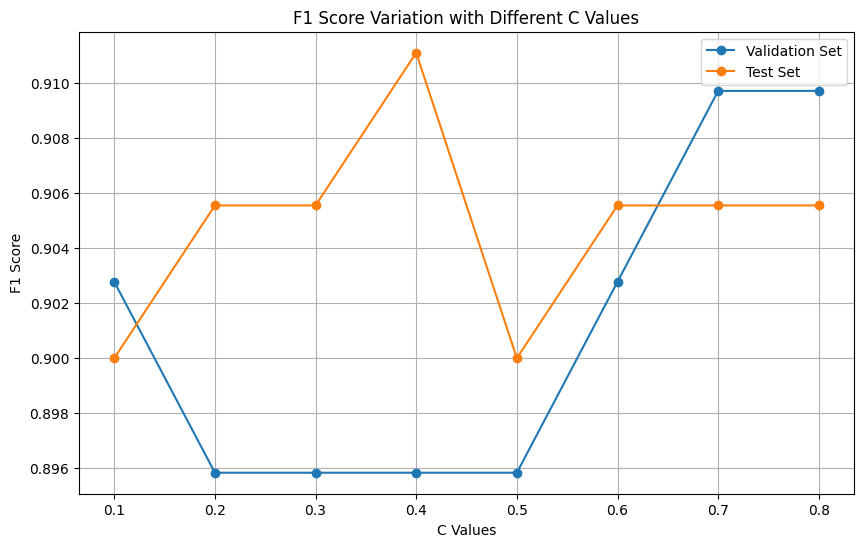

In [17]:
import matplotlib.pyplot as plt

def plot_f1_scores_variation(evaluation_results, c_values):
    f1_scores_val = [result['F1 Score Validation'] for result in evaluation_results]
    f1_scores_test = [result['F1 Score Test'] for result in evaluation_results]

    plt.figure(figsize=(10, 6))
    plt.plot(c_values, f1_scores_val, marker='o', label='Validation Set')
    plt.plot(c_values, f1_scores_test, marker='o', label='Test Set')
    plt.xlabel('C Values')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Variation with Different C Values')
    plt.xticks(c_values)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_scores_variation(evaluation_results, c_values)



In [18]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def modelling_logistic_regression_with_solvers(x_train, x_val, x_test, y_train, y_val, y_test, solver_parameters):
    # Create an empty list to store the evaluation results for each solver parameter
    evaluation_results = []

    for solver in solver_parameters:
        # Initialize Logistic Regression model with specified solver parameter
        model = LogisticRegression(solver=solver)

        # Train the Logistic Regression model
        model.fit(x_train, y_train)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)
        # Predict on the test set
        y_pred_test = model.predict(x_test)

        # Calculate confusion matrix and F1 score for validation set
        confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')

        # Calculate confusion matrix and F1 score for test set
        confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
        f1_score_test = f1_score(y_test, y_pred_test, average='micro')

        # Append evaluation results for the current solver parameter to the list
        evaluation_results.append({
            'Solver Parameter': solver,
            'Confusion Matrix Validation': confusion_matrix_val,
            'F1 Score Validation': f1_score_val,
            'Confusion Matrix Test': confusion_matrix_test,
            'F1 Score Test': f1_score_test
        })

        # Print evaluation results for the current solver parameter
        print(f"Evaluation results for Solver Parameter={solver}:")
        print(f"Validation Set - F1 Score: {f1_score_val:.4f}")
        print(f"Test Set - F1 Score: {f1_score_test:.4f}")
        print()

    return evaluation_results

# Example usage:
solver_parameters = ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
evaluation_results = modelling_logistic_regression_with_solvers(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, solver_parameters)



Evaluation results for Solver Parameter=liblinear:
Validation Set - F1 Score: 0.9028
Test Set - F1 Score: 0.9056

Evaluation results for Solver Parameter=lbfgs:
Validation Set - F1 Score: 0.9028
Test Set - F1 Score: 0.9222

Evaluation results for Solver Parameter=newton-cg:
Validation Set - F1 Score: 0.9028
Test Set - F1 Score: 0.9222

Evaluation results for Solver Parameter=newton-cholesky:
Validation Set - F1 Score: 0.9028
Test Set - F1 Score: 0.8944

Evaluation results for Solver Parameter=sag:
Validation Set - F1 Score: 0.8889
Test Set - F1 Score: 0.9222

Evaluation results for Solver Parameter=saga:
Validation Set - F1 Score: 0.8889
Test Set - F1 Score: 0.9167



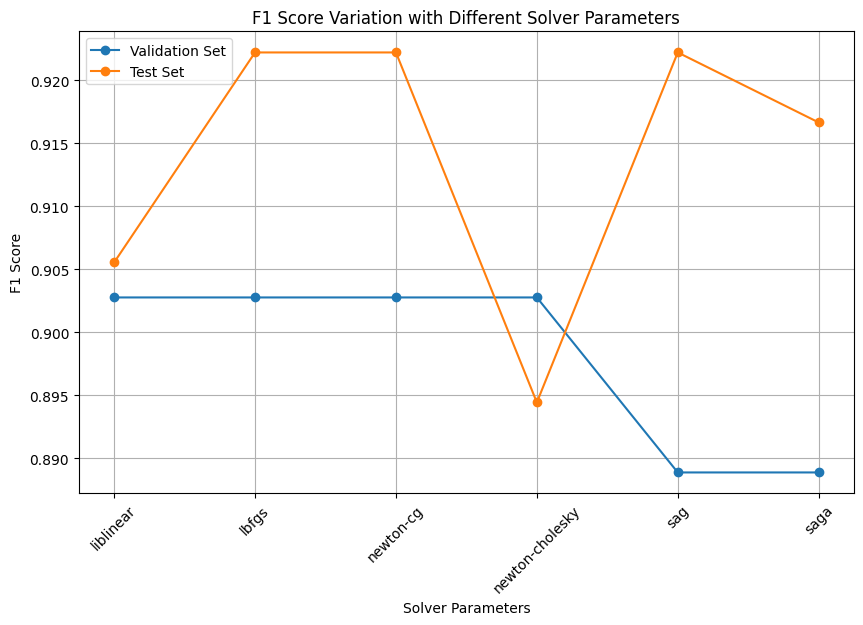

In [19]:
import matplotlib.pyplot as plt

def plot_f1_scores_variation(evaluation_results, solver_parameters):
    f1_scores_val = [result['F1 Score Validation'] for result in evaluation_results]
    f1_scores_test = [result['F1 Score Test'] for result in evaluation_results]

    plt.figure(figsize=(10, 6))
    plt.plot(solver_parameters, f1_scores_val, marker='o', label='Validation Set')
    plt.plot(solver_parameters, f1_scores_test, marker='o', label='Test Set')
    plt.xlabel('Solver Parameters')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Variation with Different Solver Parameters')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_scores_variation(evaluation_results, solver_parameters)

In [20]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def modelling_logistic_regression(x_train, x_val, x_test, y_train, y_val, y_test, multi_class_parameters):
    # Create an empty list to store the evaluation results for each combination of solver and multi_class parameters
    evaluation_results = []

    
    for multi_class in multi_class_parameters:
            # Initialize Logistic Regression model with specified solver and multi_class parameters
            model = LogisticRegression(multi_class=multi_class)

            # Train the Logistic Regression model
            model.fit(x_train, y_train)

            # Predict on the validation set
            y_pred_val = model.predict(x_val)
            # Predict on the test set
            y_pred_test = model.predict(x_test)

            # Calculate confusion matrix and F1 score for validation set
            confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
            f1_score_val = f1_score(y_val, y_pred_val, average='micro')

            # Calculate confusion matrix and F1 score for test set
            confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
            f1_score_test = f1_score(y_test, y_pred_test, average='micro')

            # Append evaluation results for the current solver and multi_class parameters to the list
            evaluation_results.append({
                'Multi_Class Parameter': multi_class,
                'Confusion Matrix Validation': confusion_matrix_val,
                'F1 Score Validation': f1_score_val,
                'Confusion Matrix Test': confusion_matrix_test,
                'F1 Score Test': f1_score_test
            })

    return evaluation_results

# Example usage:
multi_class_parameters = ['ovr', 'multinomial']
evaluation_results = modelling_logistic_regression(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, multi_class_parameters)


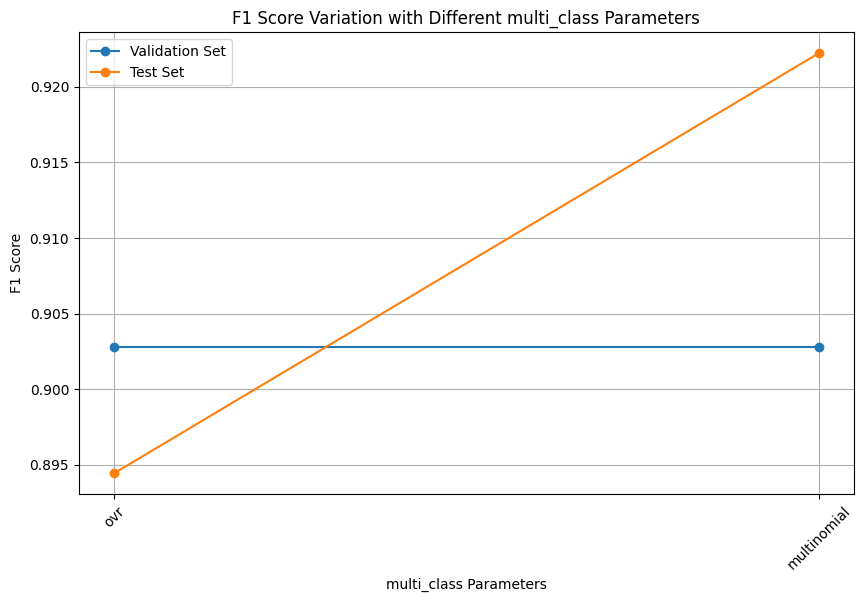

In [21]:
import matplotlib.pyplot as plt

def plot_f1_scores_variation(evaluation_results, multi_class_parameters):
    f1_scores_val = [result['F1 Score Validation'] for result in evaluation_results]
    f1_scores_test = [result['F1 Score Test'] for result in evaluation_results]

    plt.figure(figsize=(10, 6))
    plt.plot(multi_class_parameters, f1_scores_val, marker='o', label='Validation Set')
    plt.plot(multi_class_parameters, f1_scores_test, marker='o', label='Test Set')
    plt.xlabel('multi_class Parameters')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Variation with Different multi_class Parameters')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_scores_variation(evaluation_results, multi_class_parameters)

In [22]:
x_train, x_val, x_test, y_train, y_val, y_test = train_test_split_data(dataframe, 'Class', test_size=0.3, random_state=42)

In [23]:
def get_numerical_and_categorical_columns(dataframe):
    
    numerical_cols = []
    categorical_cols = []
    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            numerical_cols.append(column)
        else:
            categorical_cols.append(column)
            
    return numerical_cols, categorical_cols

numerical_cols, categorical_cols=get_numerical_and_categorical_columns(dataframe)

def Winsorization_Method(columns, x_train, y_train , a, b):
    outliers=[]

    for col in columns:
        q1= np.percentile(x_train[col], a)
        q2= np.percentile(x_train[col],b)
        
        for pos in range(len(x_train)):
            if x_train[col].iloc[pos]>q2 or x_train[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers= set(outliers)                   # remove the duplicates from the outliers
    outliers= list(outliers)
    
    ratio= round(len(outliers)/len(x_train)*100, 2)                       # Ratio of outliers
    x_train.drop(x_train.index[outliers], inplace=True)    # remove the outliers from the training dataset
    y_train.drop(y_train.index[outliers], inplace=True)
    
    
    
    return ratio, x_train, y_train

ratio_of_outliers,x_train,y_train= Winsorization_Method(numerical_cols, x_train, y_train, a=0.2, b=99.2)

robust_scaler = RobustScaler()
x_train_scaled = robust_scaler.fit_transform(x_train)
x_val_scaled = robust_scaler.transform(x_val)
x_test_scaled = robust_scaler.transform(x_test)   

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [24]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def modelling_logistic_regression_with_c_values(x_train, x_val, x_test, y_train, y_val, y_test, c_values):
    # Create an empty list to store the evaluation results for each value of C
    evaluation_results = []

    for c in c_values:
        # Initialize Logistic Regression model with specified C value
        model = LogisticRegression(C = c)


        # Train the Logistic Regression model
        model.fit(x_train, y_train)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)
        # Predict on the test set
        y_pred_test = model.predict(x_test)

        # Calculate confusion matrix and F1 score for validation set
        confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')

        # Calculate confusion matrix and F1 score for test set
        confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
        f1_score_test = f1_score(y_test, y_pred_test, average='micro')

        # Append evaluation results for the current C value to the list
        evaluation_results.append({
            'C': c,
            'Confusion Matrix Validation': confusion_matrix_val,
            'F1 Score Validation': f1_score_val,
            'Confusion Matrix Test': confusion_matrix_test,
            'F1 Score Test': f1_score_test
        })

        # # Print evaluation results for the current C value
        # print(f"Evaluation results for C={c}:")
        # print(f"Validation Set - F1 Score: {f1_score_val:.4f}")
        # print(f"Test Set - F1 Score: {f1_score_test:.4f}")
        # print()

    return evaluation_results

# Example usage:
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
evaluation_results = modelling_logistic_regression_with_c_values(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, c_values)


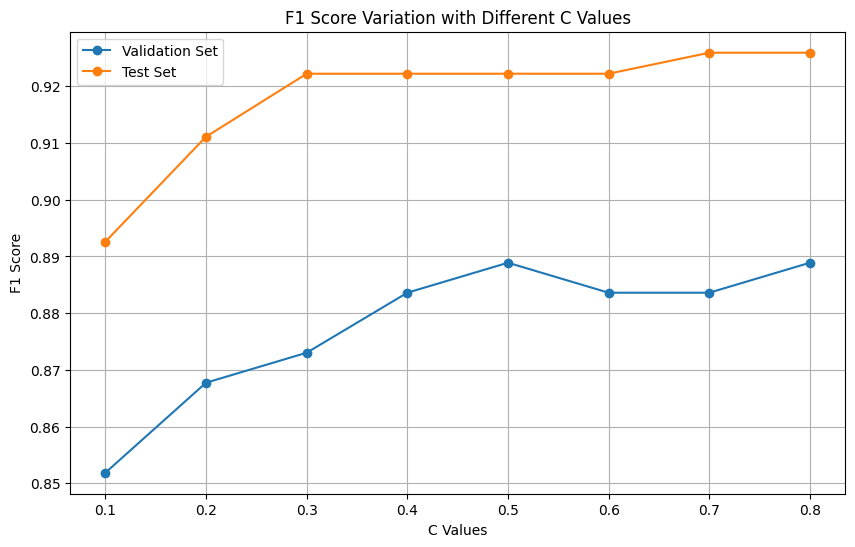

In [25]:
import matplotlib.pyplot as plt

def plot_f1_scores_variation(evaluation_results, c_values):
    f1_scores_val = [result['F1 Score Validation'] for result in evaluation_results]
    f1_scores_test = [result['F1 Score Test'] for result in evaluation_results]

    plt.figure(figsize=(10, 6))
    plt.plot(c_values, f1_scores_val, marker='o', label='Validation Set')
    plt.plot(c_values, f1_scores_test, marker='o', label='Test Set')
    plt.xlabel('C Values')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Variation with Different C Values')
    plt.xticks(c_values)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_scores_variation(evaluation_results, c_values)



In [26]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

def oversample_data(x_train, y_train):
    # Instantiate SMOTE
    smote = SMOTE(random_state=42)

    # Apply SMOTE to the training data
    x_train_oversampled, y_train_oversampled = smote.fit_resample(x_train, y_train)
    
    return x_train_oversampled, y_train_oversampled

def modelling_logistic_regression_with_c_values(x_train, x_val, x_test, y_train, y_val, y_test, c_values):
    # Create an empty list to store the evaluation results for each value of C
    evaluation_results = []

    for c in c_values:
        # Initialize Logistic Regression model with specified C value
        model = LogisticRegression(C=c)

        # Oversample the training data
        x_train_oversampled, y_train_oversampled = oversample_data(x_train, y_train)

        # Train the Logistic Regression model with oversampled data
        model.fit(x_train_oversampled, y_train_oversampled)

        # Predict on the validation set
        y_pred_val = model.predict(x_val)
        # Predict on the test set
        y_pred_test = model.predict(x_test)

        # Calculate confusion matrix and F1 score for validation set
        confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
        f1_score_val = f1_score(y_val, y_pred_val, average='micro')

        # Calculate confusion matrix and F1 score for test set
        confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
        f1_score_test = f1_score(y_test, y_pred_test, average='micro')

        # Append evaluation results for the current C value to the list
        evaluation_results.append({
            'C': c,
            'Confusion Matrix Validation': confusion_matrix_val,
            'F1 Score Validation': f1_score_val,
            'Confusion Matrix Test': confusion_matrix_test,
            'F1 Score Test': f1_score_test
        })

        # Print evaluation results for the current C value
        print(f"Evaluation results for C={c}:")
        print(f"Validation Set - F1 Score: {f1_score_val:.4f}")
        print(f"Test Set - F1 Score: {f1_score_test:.4f}")
        print()

    return evaluation_results

# Load your data and preprocess it (e.g., standardization)
# x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(data, target)
# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train)
# x_val_scaled = scaler.transform(x_val)
# x_test_scaled = scaler.transform(x_test)

# Set the values of C to be tested
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Call the modelling function with logistic regression and C values
evaluation_results = modelling_logistic_regression_with_c_values(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, c_values)


Evaluation results for C=0.1:
Validation Set - F1 Score: 0.8995
Test Set - F1 Score: 0.9148

Evaluation results for C=0.2:
Validation Set - F1 Score: 0.8942
Test Set - F1 Score: 0.9222

Evaluation results for C=0.3:
Validation Set - F1 Score: 0.8995
Test Set - F1 Score: 0.9111

Evaluation results for C=0.4:
Validation Set - F1 Score: 0.8995
Test Set - F1 Score: 0.9111

Evaluation results for C=0.5:
Validation Set - F1 Score: 0.8995
Test Set - F1 Score: 0.9074

Evaluation results for C=0.6:
Validation Set - F1 Score: 0.8942
Test Set - F1 Score: 0.9000

Evaluation results for C=0.7:
Validation Set - F1 Score: 0.8995
Test Set - F1 Score: 0.9000

Evaluation results for C=0.8:
Validation Set - F1 Score: 0.8995
Test Set - F1 Score: 0.9000



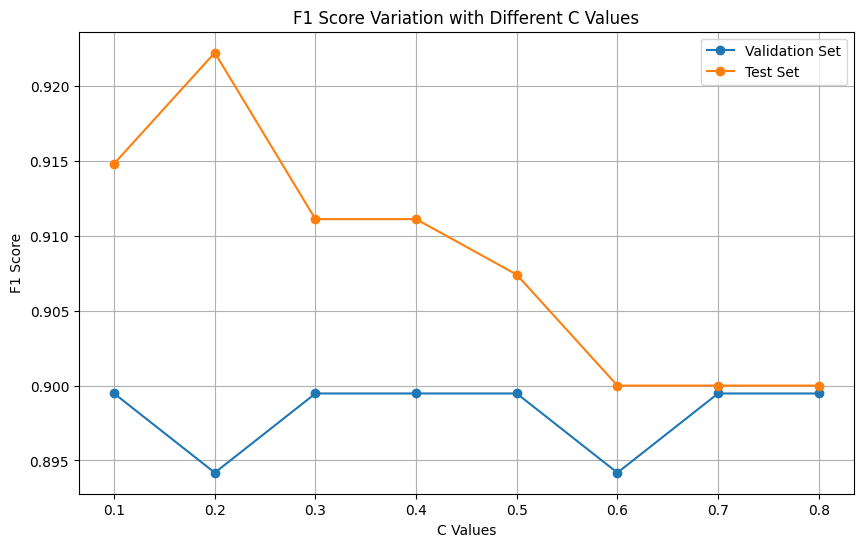

In [27]:
import matplotlib.pyplot as plt

def plot_f1_scores_variation(evaluation_results, c_values):
    f1_scores_val = [result['F1 Score Validation'] for result in evaluation_results]
    f1_scores_test = [result['F1 Score Test'] for result in evaluation_results]

    plt.figure(figsize=(10, 6))
    plt.plot(c_values, f1_scores_val, marker='o', label='Validation Set')
    plt.plot(c_values, f1_scores_test, marker='o', label='Test Set')
    plt.xlabel('C Values')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Variation with Different C Values')
    plt.xticks(c_values)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_scores_variation(evaluation_results, c_values)



Evaluation results for Solver Parameter=liblinear:
Validation Set - F1 Score: 0.8783
Test Set - F1 Score: 0.8926

Evaluation results for Solver Parameter=lbfgs:
Validation Set - F1 Score: 0.8942
Test Set - F1 Score: 0.9222

Evaluation results for Solver Parameter=newton-cg:
Validation Set - F1 Score: 0.8942
Test Set - F1 Score: 0.9222

Evaluation results for Solver Parameter=newton-cholesky:
Validation Set - F1 Score: 0.8889
Test Set - F1 Score: 0.9037

Evaluation results for Solver Parameter=sag:
Validation Set - F1 Score: 0.8889
Test Set - F1 Score: 0.9148

Evaluation results for Solver Parameter=saga:
Validation Set - F1 Score: 0.8836
Test Set - F1 Score: 0.9185



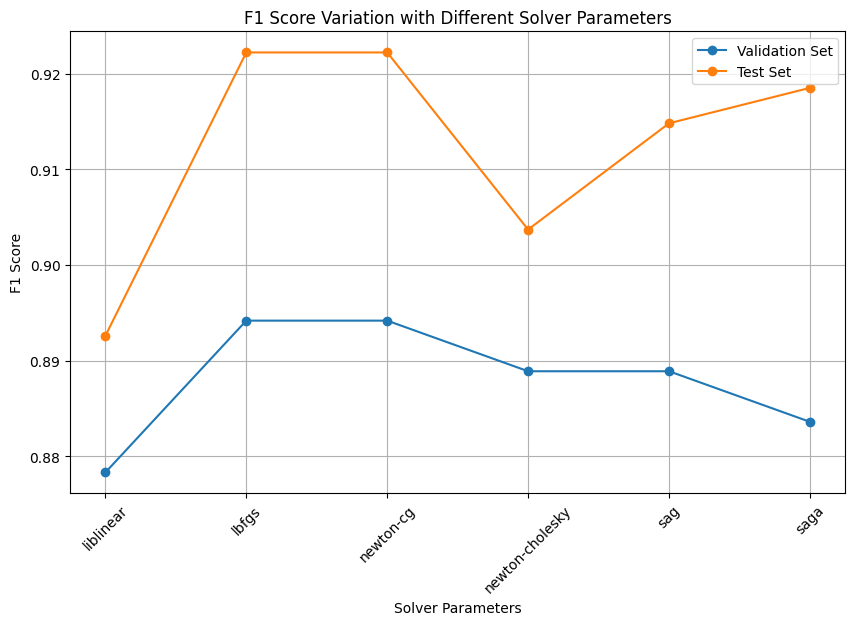

In [28]:
evaluation_results = modelling_logistic_regression_with_solvers(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, solver_parameters)
import matplotlib.pyplot as plt

def plot_f1_scores_variation(evaluation_results, solver_parameters):
    f1_scores_val = [result['F1 Score Validation'] for result in evaluation_results]
    f1_scores_test = [result['F1 Score Test'] for result in evaluation_results]

    plt.figure(figsize=(10, 6))
    plt.plot(solver_parameters, f1_scores_val, marker='o', label='Validation Set')
    plt.plot(solver_parameters, f1_scores_test, marker='o', label='Test Set')
    plt.xlabel('Solver Parameters')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Variation with Different Solver Parameters')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_scores_variation(evaluation_results, solver_parameters)


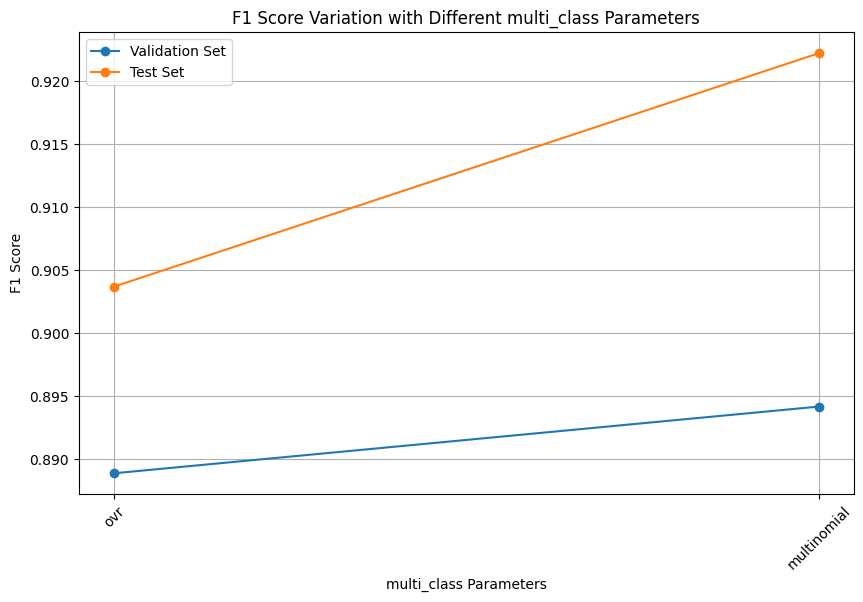

In [29]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def modelling_logistic_regression(x_train, x_val, x_test, y_train, y_val, y_test, multi_class_parameters):
    # Create an empty list to store the evaluation results for each combination of solver and multi_class parameters
    evaluation_results = []

    
    for multi_class in multi_class_parameters:
            # Initialize Logistic Regression model with specified solver and multi_class parameters
            model = LogisticRegression(multi_class=multi_class)

            # Train the Logistic Regression model
            model.fit(x_train, y_train)

            # Predict on the validation set
            y_pred_val = model.predict(x_val)
            # Predict on the test set
            y_pred_test = model.predict(x_test)

            # Calculate confusion matrix and F1 score for validation set
            confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
            f1_score_val = f1_score(y_val, y_pred_val, average='micro')

            # Calculate confusion matrix and F1 score for test set
            confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
            f1_score_test = f1_score(y_test, y_pred_test, average='micro')

            # Append evaluation results for the current solver and multi_class parameters to the list
            evaluation_results.append({
                'Multi_Class Parameter': multi_class,
                'Confusion Matrix Validation': confusion_matrix_val,
                'F1 Score Validation': f1_score_val,
                'Confusion Matrix Test': confusion_matrix_test,
                'F1 Score Test': f1_score_test
            })

    return evaluation_results

# Example usage:
multi_class_parameters = ['ovr', 'multinomial']
evaluation_results = modelling_logistic_regression(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, multi_class_parameters)

import matplotlib.pyplot as plt

def plot_f1_scores_variation(evaluation_results, multi_class_parameters):
    f1_scores_val = [result['F1 Score Validation'] for result in evaluation_results]
    f1_scores_test = [result['F1 Score Test'] for result in evaluation_results]

    plt.figure(figsize=(10, 6))
    plt.plot(multi_class_parameters, f1_scores_val, marker='o', label='Validation Set')
    plt.plot(multi_class_parameters, f1_scores_test, marker='o', label='Test Set')
    plt.xlabel('multi_class Parameters')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Variation with Different multi_class Parameters')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_scores_variation(evaluation_results, multi_class_parameters)
